# AI Automation for AI Fairness

When AI models contribute to high-impact decisions such as whether or
not someone gets a loan, we want them to be fair.
Unfortunately, in current practice, AI models are often optimized
primarily for accuracy, with little consideration for fairness.  This
blog post gives a hands-on example for how AI Automation can help build AI
models that are both accurate and fair.
This blog post is written for data scientists who have some familiarity
with Python. No prior knowledge of AI Automation or AI Fairness is
required, we will introduce the relevant concepts as we get to them.

Bias in data leads to bias in models. AI models are increasingly
consulted for consequential decisions about people, in domains
including credit loans, hiring and retention, penal justice, medical,
and more. Often, the model is trained from past decisions made by
humans. If the decisions used for training were discriminatory, then
your trained model will be too, unless you are careful. Being careful
about bias is something you should do as a data scientist.
Fortunately, you do not have to grapple with this issue alone.  You
can consult others about ethics. You can also ask yourself how your AI
model may affect your (or your institution's) reputation. And
ultimately, you must follow applicable laws and regulations.

_AI Fairness_ can be measured via several metrics, and you need to
select the appropriate metrics based on the circumstances.  For
illustration purposes, this blog post uses one particular fairness
metric called _disparate impact_. Disparate impact is defined as the
ratio of the rate of favorable outcome for the unprivileged group to
that of the privileged group. To make this definition more concrete,
consider the case where a favorable outcome means getting a loan, the
unprivileged group is women, and the privileged group is men.  Then if
your AI model were to let women get a loan in 30% of the cases and men
in 60% of the cases, the disparate impact would be 30% / 60% = 0.5,
indicating a gender bias towards men.  The ideal value for disparate
impact is 1, and you could define fairness for this metric as a band
around 1, e.g., from 0.8 to 1.2.

To get the best performance out of your AI model, you must experiment
with its configuration. This means searching a high-dimensional space
where some options are categorical, some are continuous, and some are
even conditional. No configuration is optimal for all domains let
alone all metrics, and searching them all by hand is impossible. In
fact, in a high-dimensional space, even exhaustively enumerating all
the valid combinations soon becomes impractical.  Fortunately, you can
use tools to automate the search, thus making you more productive at
finding good models quickly. These productivity and quality
improvements become compounded when you have to do the search over.

_AI Automation_ is a technology that assists data scientists in
building AI models by automating some of the tedious steps. One AI
automation technique is _algorithm selection_ , which automatically
chooses among alternative algorithms for a particular task. Another AI
automation technique is _hyperparameter tuning_ , which automatically
configures the arguments of AI algorithms. You can use AI automation
to optimize for a variety of metrics.  This blog post shows you how to use AI
automation to optimize for both accuracy and for fairness as measured
by disparate impact.

This blog post is generated from a [Jupyter](https://jupyter.org/)
notebook that uses the following open-source Python libraries. 
[AIF360](https://aif360.mybluemix.net/) 
is a collection of fairness metrics and bias mitigation algorithms.
The [pandas](https://pandas.pydata.org/),
[scikit-learn](https://scikit-learn.org/), and
[XGBoost](https://xgboost.ai/) libraries support
data analysis and machine learning with data structures and a
comprehensive collection of AI algorithms.
The [hyperopt](http://hyperopt.github.io/hyperopt/) library
implements both algorithm selection and hyperparameter tuning for
AI automation.
And [Lale](https://github.com/IBM/lale) is a library for
semi-automated data science; this blog post uses Lale as the backbone
for putting the other libraries together.

Our starting point is a dataset and a task. For illustration
purposes, we picked [credit-g](https://www.openml.org/d/31), also
known as the German Credit dataset. Each row describes a person
using several features that may help evaluate them as a potential
loan applicant. The task is to classify people into either
good or bad credit risks. We load a version of the dataset prepared
for AIF360.

In [1]:
from lale.lib.aif360 import fetch_creditg_df
(train_X, train_y), (test_X, test_y) = fetch_creditg_df()

To see what the dataset looks like, we can use off-the-shelf
functionality from pandas for inspecting the shape and the first few
rows.  The creditg dataset has a single label column, `class`, to be
predicted as the outcome.
A _protected attribute_ is a feature that partitions the population
into groups whose outcome should have parity. The credit-g dataset has
two protected attribute columns, `sex` and `age`.

In [2]:
import pandas as pd
print(f'train_X.shape {train_X.shape}')
pd.options.display.max_columns = None
pd.concat([train_y.head(10), train_X.head(10)], axis=1)

train_X.shape (670, 58)


,class,checking_status_0<=X<200,checking_status_<0,checking_status_>=200,checking_status_no checking,credit_history_all paid,credit_history_critical/other existing credit,credit_history_delayed previously,credit_history_existing paid,credit_history_no credits/all paid,purpose_business,purpose_domestic appliance,purpose_education,purpose_furniture/equipment,purpose_new car,purpose_other,purpose_radio/tv,purpose_repairs,purpose_retraining,purpose_used car,savings_status_100<=X<500,savings_status_500<=X<1000,savings_status_<100,savings_status_>=1000,savings_status_no known savings,employment_1<=X<4,employment_4<=X<7,employment_<1,employment_>=7,employment_unemployed,other_parties_co applicant,other_parties_guarantor,other_parties_none,property_magnitude_car,property_magnitude_life insurance,property_magnitude_no known property,property_magnitude_real estate,other_payment_plans_bank,other_payment_plans_none,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes,foreign_worker_no,foreign_worker_yes,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,sex
863,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,27.0,4526.0,4.0,2.0,1.0,2.0,2.0,1.0
748,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,21.0,5248.0,1.0,3.0,1.0,1.0,1.0,1.0
64,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,24.0,3181.0,4.0,4.0,1.0,1.0,1.0,0.0
798,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,24.0,717.0,4.0,4.0,1.0,2.0,1.0,1.0
52,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,12.0,1262.0,3.0,2.0,0.0,1.0,1.0,1.0
440,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,12.0,1884.0,4.0,4.0,1.0,1.0,1.0,1.0
124,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,18.0,1924.0,4.0,3.0,1.0,1.0,1.0,0.0
650,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,48.0,7476.0,4.0,1.0,1.0,1.0,1.0,1.0
409,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,12.0,939.0,4.0,2.0,1.0,3.0,1.0,1.0
752,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,12.0,841.0,2.0,4.0,0.0,1.0,1.0,0.0


Before we look at how to train a classifier that is optimized for both
accuracy and disparate impact, we will set a baseline, by training a
pipeline that is only optimized for accuracy. For this purpose, we
import a few algorithms from scikit-learn: a dimensionality reduction
transformer (PCA) and three classifiers (logistic regression, gradient
boosting, and a support vector machine).

In [3]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.svm import LinearSVC as SVM

To use AI Automation, we need to define a _search space_ ,
which is a set of possible machine learning pipelines and
their associated hyperparameters. The following code
uses Lale to define a search space.

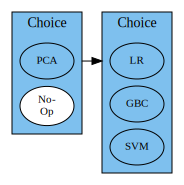

In [4]:
from lale.lib.lale import NoOp
import lale
lale.wrap_imported_operators()
planned_orig = (PCA | NoOp) >> (LR | GBC | SVM)
planned_orig.visualize()

The call to `wrap_imported_operators` augments the algorithms
that were imported from scikit-learn with metadata about
their hyperparameters. The Lale combinator `|` indicates
algorithmic choice. For example, `(PCA | NoOp)` indicates that
it is up to the AI Automation to decide whether to apply a PCA
transformer or whether to use a no-op transformer that leaves
the data unchanged. Note that the `PCA` itself is not configured
with concrete hyperparameters, since those will be left for the
AI automation to choose instead. Finally, the Lale combinator
`>>` pipes the output from the transformer into the input to the
classifier, which is itself a choice between `(LR | GBC | SVM)`.
The search space is encapsulated in the object `planned_orig`.

We will use hyperopt to select the algorithms and to tune their
hyperparameters. Lale provides a `Hyperopt` that
turns a search space such as the one specified above into an
optimization problem for hyperopt. After 10 trials, we get back
the model that performed best for the default optimization
objective, which is accuracy.

100%|███████| 10/10 [00:46<00:00,  4.64s/trial, best loss: -0.7492526158445442]
1 out of 10 trials failed, call summary() for details.
Run with verbose=True to see per-trial exceptions.


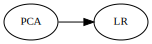

In [5]:
from lale.lib.lale import Hyperopt
best_estimator = planned_orig.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, max_evals=10)
best_estimator.visualize()

As shown by the visualization, the search found a pipeline
with a PCA transformer and an LR classifier.
Inspecting the hyperparameters reveals which values
worked best for the 10 trials on the dataset at hand.

In [6]:
best_estimator.pretty_print(ipython_display=True, show_imports=False)

```python
pca = PCA(svd_solver="full", whiten=True)
lr = LR(
    dual=True,
    intercept_scaling=0.3725797779832578,
    max_iter=802,
    multi_class="ovr",
    solver="liblinear",
    tol=0.008013565529132195,
)
pipeline = pca >> lr
```

We can use the accuracy score metric from scikit-learn to measure
how well the pipeline accomplishes the objective for which it
was trained.

In [7]:
import sklearn.metrics
accuracy_scorer = sklearn.metrics.make_scorer(sklearn.metrics.accuracy_score)
print(f'accuracy {accuracy_scorer(best_estimator, test_X, test_y):.1%}')

accuracy 74.5%


The accuracy is close to the state of the art for this dataset.
However, we would like our model to be not just accurate but also fair.
As discussed before, we will use disparate impact as the fairness metric.
To configure the metric, we need some fairness-related metadata.
The favorable and unfavorable label are values of the target `class`
column that indicate whether the loan was granted or denied.
For illustrative purposes, we will only look at one of the protected
attributes, `sex`, which in this dataset is encoded as 0 for female
(unprivileged group) and 1 for male (privileged group).

In [8]:
fairness_info = {
    "favorable_labels": [1],
    "protected_attributes": [
        {"feature": "sex", "privileged_groups": [1]}]}

We will use the disparate impact metric from AIF360, wrapped for
compatibility with scikit-learn.

In [9]:
import aif360.metrics
disparate_impact_scorer = lale.lib.aif360.disparate_impact(**fairness_info)
print(f'disparate impact {disparate_impact_scorer(best_estimator, test_X, test_y):.2f}')

disparate impact 0.91


The disparate impact for this model is 0.91, which differs from
the ideal value for this metric, which is 1.0. We would prefer a
model that is much more fair. The AIF360 toolkit provides several
algorithms for mitigating fairness problems. One of them is
`DisparateImpactRemover`, which modifies the features that are
not the protected attribute in such a way that it is hard to
predict the protected attribute from them. We use a Lale version
of `DisparateImpactRemover` that wraps the corresponding AIF360
algorithm for AI Automation. This algorithm has a hyperparameter
`repair_level` that we will tune with hyperparameter optimization.

In [10]:
from lale.lib.aif360 import DisparateImpactRemover
DisparateImpactRemover.hyperparam_schema('repair_level')

{'description': 'Repair amount from 0 = none to 1 = full.',
 'type': 'number',
 'minimum': 0,
 'maximum': 1,
 'default': 1}

We compose the bias mitigation algorithm in a pipeline with
a choice of classifiers as before.
In the visualization, light blue indicates trainable operators
and dark blue indicates that automation must make a choice before
the operators can be trained. Compared to the earlier pipeline,
we omit the PCA, to make it easier for the estimator to disregard
features that cause poor disparate impact.

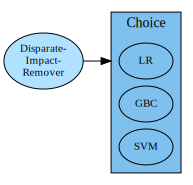

In [11]:
di_remover = DisparateImpactRemover(**fairness_info)
planned_fairer = di_remover >> (LR | GBC | SVM)
planned_fairer.visualize()

Unlike accuracy, which is a metric that can be computed from
predicted labels alone, fairness metrics such as disparate
impact need to look not just at labels but also at features.
For instance, disparate impact is defined by comparing outcomes
between a privileged group and an unprivileged group, so it
needs to check the protected attribute to determine group
membership for the sample person at hand. In order to use Lale Hyperopt for this
case, we will have to define a custom scorer that takes the disparate impact into account
along with accuracy. Hyperopt minimizes `(best_score - score_returned_by_the_scorer)`, where `best_score` 
is an argument to Hyperopt and `score_returned_by_the_scorer` is the value returned by the scorer for each
evaluation point. In the custom scorer defined below, if the disparate impact is outside of  a margin of 10% around its ideal of 1, the score is -99, a low value. Otherwise, the score is accuracy, higher is better.

In [12]:
def combined_scorer(estimator, X, y):
    accuracy = accuracy_scorer(estimator, X, y)
    disparate_impact = disparate_impact_scorer(estimator, X, y)
    if disparate_impact < 0.9 or 1.1 < disparate_impact:
        return -99
    else:
        return accuracy

Now, we have all the pieces in place to use AI Automation
on our `planned_fairer` pipeline for both accuracy and
disparate impact.

In [13]:
trained_fairer = planned_fairer.auto_configure(
    train_X, train_y, optimizer=Hyperopt, cv=3, verbose=True,
    max_evals=10, scoring=combined_scorer, best_score=1.0)

100%|████████| 10/10 [03:12<00:00, 19.23s/trial, best loss: 0.2626788383514841]


As with any trained model, we can evaluate and visualize the result.

accuracy 75.8%
disparate impact 0.99


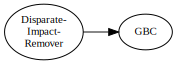

In [14]:
print(f'accuracy {accuracy_scorer(trained_fairer, test_X, test_y):.1%}')
print(f'disparate impact {disparate_impact_scorer(trained_fairer, test_X, test_y):.2f}')
trained_fairer.visualize()

As the result demonstrates, the best model found by AI Automation
has similar accuracy and better disparate impact than the one we saw
before. Also, it has tuned the repair level and
has picked and tuned a classifier.

In [15]:
trained_fairer.pretty_print(ipython_display=True, show_imports=False)

```python
disparate_impact_remover = DisparateImpactRemover(
    favorable_labels=[1],
    protected_attributes=[{"feature": "sex", "privileged_groups": [1]}],
    repair_level=0.6502841017477625,
)
gbc = GBC(
    loss="exponential",
    max_features=0.6237393417944076,
    min_samples_leaf=19,
    min_samples_split=15,
    n_estimators=28,
)
pipeline = disparate_impact_remover >> gbc
```

These results may vary by dataset and search space.

In summary, this blog post showed you how to use AI Automation
from Lale, while incorporating a fairness mitigation technique
into the pipeline and a fairness metric into the objective.
Of course, this blog post only scratches the surface of what can
be done with AI Automation and AI Fairness. We encourage you to
check out the open-source projects Lale and AIF360 and use them
to build your own fair and accurate models!

- Lale: https://github.com/IBM/lale
- AIF360: https://aif360.mybluemix.net/

The following notebook showcases how Lale exposes a few more
operators and metrics from AIF360:
https://nbviewer.jupyter.org/github/IBM/lale/blob/master/examples/demo_aif360_more.ipynb